<a href="https://colab.research.google.com/github/jiheddachraoui/occupancy_grid_generator/blob/main/2_SG_Fusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PREPARATION

In [1]:
import os
import sys
import csv
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
from collections import Counter
import tensorflow as tf
from sklearn.linear_model import RANSACRegressor
from scipy import stats
from google.colab import drive
drive.mount('/content/drive',force_remount=True)


Mounted at /content/drive


In [2]:
### Load carla data
datadir = '/content/drive/MyDrive/s_data/'
scenario='ground truth/scenario5_gt'

vehicles=[]
for item in os.listdir(os.path.join(datadir,scenario)):
  vehicles.append(item)
vehicle1=vehicles[0]
vehicle2=vehicles[1]
folder_path1 = os.path.join(datadir,scenario,vehicle1)
folder_path2 = os.path.join(datadir,scenario,vehicle2)
print(folder_path1)
print(folder_path2)


/content/drive/MyDrive/s_data/ground truth/scenario5_gt/Vehicle_3 vehicle.citroen.c3
/content/drive/MyDrive/s_data/ground truth/scenario5_gt/Ego_1 vehicle.audi.a2


In [3]:
LABEL_COLORS = np.array([
    (255, 255, 255), # None
    (80, 80, 80),    # Building
    (100, 40, 40),   # Fences
    (55, 90, 80),    # Other
    (220, 20, 60),   # Pedestrian
    (153, 153, 153), # Pole
    (157, 234, 50),  # RoadLines
    (128, 64, 128),  # Road
    (244, 35, 232),  # Sidewalk
    (107, 142, 35),  # Vegetation
    (0, 0, 142),     # Vehicle
    (102, 102, 156), # Wall
    (220, 220, 0),   # TrafficSign
    (70, 130, 180),  # Sky
    (81, 0, 81),     # Ground
    (150, 100, 100), # Bridge
    (230, 150, 140), # RailTrack
    (180, 165, 180), # GuardRail
    (250, 170, 30),  # TrafficLight
    (110, 190, 160), # Static
    (170, 120, 50),  # Dynamic
    (45, 60, 150),   # Water
    (145, 170, 100), # Terrain
]) / 255.0 # normalize each channel [0-1] since is what Open3D uses

REDUCED_LABEL_COLORS = np.array([
    (255, 255, 255), # None
    (128, 64, 128),  # Road RoadLines
    (80, 80, 80),    # Building,Wall, static ,Fences
    (250, 170, 30),    # Other ,GuardRail ,RailTrack ,15Bridge
    (110, 190, 160), # Pole ;TrafficLight; Static
    (107, 142, 35),  # Vegetation
    (0, 0, 142),     # Vehicle Dynamic pedestrians
    (244, 35, 232),  # Sidewalk Ground Terrain
    (70, 130, 180),   # Water

]) / 255.0 # normalize each channel [0-1] since is what Open3D uses
label_names = [
    'None', 'Building', 'Fences', 'Other', 'Pedestrian', 'Pole', 'RoadLines',
    'Road', 'Sidewalk', 'Vegetation', 'Vehicle', 'Wall', 'TrafficSign', 'Sky',
    'Ground', 'Bridge', 'RailTrack', 'GuardRail', 'TrafficLight', 'Static',
    'Dynamic', 'Water', 'Terrain'
]

reduced_label_names = [
    'None', 'Road', 'Building', 'Bridge, Rail, Other', 'Static', 'Vegetation', 'Dynamic',
    'Ground', 'Water'
]

## Get Data

In [4]:
date =10

In [5]:
def load_matrix(folder_path,timestamp):
  ts = str(timestamp)
  for file_name in os.listdir(folder_path):
          if os.path.splitext(file_name)[0] == ts:

              file_path = os.path.join(folder_path,file_name)
              print(file_path)
              break

  m=np.load(file_path)
  return m

In [7]:
### Retrieve the provided calibration data
#matrix transforms the points from lidar space to world space.

transformation_matrices_path=os.path.join(folder_path1, "pos_matrices/lidar_2_world")
transformation_matrices_path1=os.path.join(folder_path2, "pos_matrices/lidar_2_world")

location_path=os.path.join(folder_path1, "location")
location_path1=os.path.join(folder_path2, "location")

ogm_path=os.path.join(folder_path1, "grids/sem_grid_gt")
ogm_path1=os.path.join(folder_path2, "grids/sem_grid_gt")



Ogm1=load_matrix(ogm_path,date)
Ogm2=load_matrix(ogm_path1,date)

rot_path=os.path.join(folder_path1, "pos_matrices/rotation_pyr")
rot_path1=os.path.join(folder_path2, "pos_matrices/rotation_pyr")

transform1=load_matrix(transformation_matrices_path,date)
transform2=load_matrix(transformation_matrices_path1,date)

#loc1=load_location(location_path,date)
#loc2=load_location(location_path1,date)

loc1=transform1[:3, 3:].flatten().tolist()
loc2=transform2[:3, 3:].flatten().tolist()

rot1=load_matrix(rot_path,date)
rot2=load_matrix(rot_path1,date)

print('vehicle1 pos: ')
print(transform1)
print()
print('vehicle1 location: ')
print(loc1)
print()
print('vehicle2 pos: ')
print(transform2)
print()
print('vehicle2 location: ')
print(loc2)
print('_________________________________________')




/content/drive/MyDrive/s_data/ground truth/scenario5_gt/Vehicle_3 vehicle.citroen.c3/grids/sem_grid_gt/10.npy
/content/drive/MyDrive/s_data/ground truth/scenario5_gt/Ego_1 vehicle.audi.a2/grids/sem_grid_gt/10.npy
/content/drive/MyDrive/s_data/ground truth/scenario5_gt/Vehicle_3 vehicle.citroen.c3/pos_matrices/lidar_2_world/10.npy
/content/drive/MyDrive/s_data/ground truth/scenario5_gt/Ego_1 vehicle.audi.a2/pos_matrices/lidar_2_world/10.npy
/content/drive/MyDrive/s_data/ground truth/scenario5_gt/Vehicle_3 vehicle.citroen.c3/pos_matrices/rotation_pyr/10.npy
/content/drive/MyDrive/s_data/ground truth/scenario5_gt/Ego_1 vehicle.audi.a2/pos_matrices/rotation_pyr/10.npy
vehicle1 pos: 
[[-8.91737640e-03 -9.99960244e-01  0.00000000e+00  3.11048462e+02]
 [ 9.99960244e-01 -8.91737640e-03 -0.00000000e+00 -1.83472885e+02]
 [ 0.00000000e+00 -0.00000000e+00  1.00000000e+00  1.84296358e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

vehicle1 location: 
[311.0484619140625, -1

In [8]:
ogm1=Ogm1[:,:,0]
ogm2=Ogm2[:,:,0]

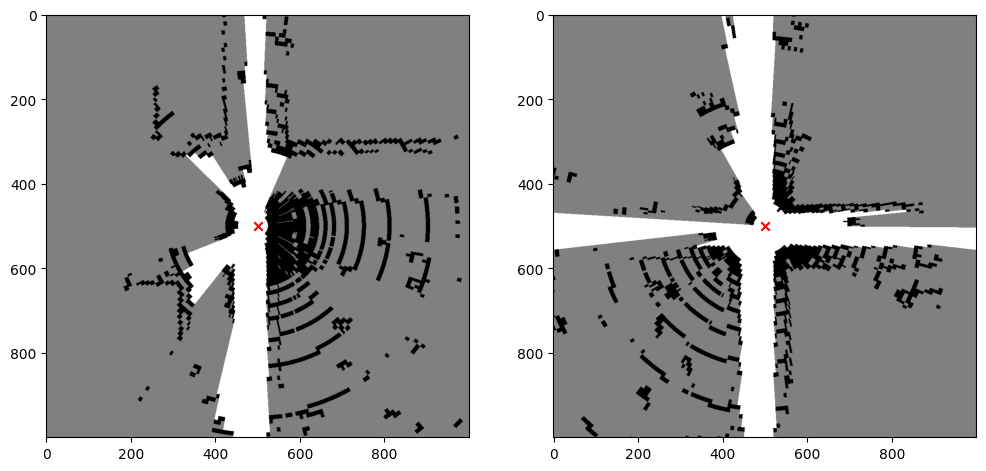

In [9]:
### Visualize
fig,axs = plt.subplots(1,2,figsize=(12,6))
axs[0].imshow(((1-ogm1)*255).astype(np.uint8),cmap='gray')
axs[0].scatter(500,500,c='r',marker='x')
axs[1].imshow(((1-ogm2)*255).astype(np.uint8),cmap='gray')
axs[1].scatter(500,500,c='r',marker='x')
plt.show()

## Shift the map


compute pose from rotation matrix:
<br>
<center><img src="https://image1.slideserve.com/3199301/roll-pitch-yaw-l.jpg" width=400px></center>
</br>

(c=cos(), s=sin())

In [10]:
# Extract the rotation matrix from the transformation matrix
R1 = np.array(transform1[:3, :3])
R2 = np.array(transform2[:3, :3])
print(R1)
print()
print(R2)

[[-0.00891738 -0.99996024  0.        ]
 [ 0.99996024 -0.00891738 -0.        ]
 [ 0.         -0.          1.        ]]

[[ 9.99883354e-01 -5.72892884e-03  1.41560910e-02]
 [ 5.72181866e-03  9.99983430e-01  5.42707799e-04]
 [-1.41589670e-02 -4.61645919e-04  9.99899626e-01]]


In [11]:
'''pitch1 = np.arcsin(R1[1, 2])
yaw1 = -np.arctan2(R1[0, 2], R1[2, 2])
roll1 = np.arctan2(R1[1, 0], R1[1, 1])'''

pitch1 = np.arcsin(R1[2, 0])
yaw1 = -np.arctan2(R1[1, 0], R1[0, 0])
roll1 = -np.arctan2(R1[2, 1], R1[2, 2])

print(pitch1* 180 / np.pi,yaw1* 180 / np.pi,roll1* 180 / np.pi)
print(rot1)

0.0 -90.51093480150894 0.0
[ 0.         90.51093292  0.        ]


In [12]:
'''pitch2 = np.arcsin(R2[1, 2])
yaw2 = -np.arctan2(R2[0, 2], R2[2, 2])
roll2 = np.arctan2(R2[1, 0], R2[1, 1])'''

pitch2 = np.arcsin(R2[2, 0])
yaw2 = -np.arctan2(R2[1, 0], R2[0, 0])
roll2 = -np.arctan2(R2[2, 1], R2[2, 2])

print(pitch2* 180 / np.pi,yaw2* 180 / np.pi,roll2* 180 / np.pi )
print(rot2)

-0.8112761570480055 -0.3278707265540813 0.026453016117173725
[-0.81127614  0.32787073  0.02645302]


In [13]:
'''yaw1=rot1[1]
yaw2=rot2[1]'''

'yaw1=rot1[1]\nyaw2=rot2[1]'

In [14]:
pose1=np.array([loc1[0],loc1[1],yaw1])
pose2=np.array([loc2[0],loc2[1],yaw2])

In [15]:
'''pose1=np.array([loc1[0],loc1[1],rot1[1]])
pose2=np.array([loc2[0],loc2[1],rot2[1]])'''

'pose1=np.array([loc1[0],loc1[1],rot1[1]])\npose2=np.array([loc2[0],loc2[1],rot2[1]])'

In [16]:
RESOLUTION = 0.1
# Calculate the relative position of the two vehicles
rel_pos = pose2[:2] - pose1[:2]
rel_orientation = pose2[2] - pose1[2]

# Define the translation and rotation matrices
#translation_matrix = np.array([[1, 0, -rel_pos[0]], [0, 1, -rel_pos[1]], [0, 0, 1]])
rotation_matrix = np.array([[np.cos(rel_orientation), -np.sin(rel_orientation), 0], [np.sin(rel_orientation), np.cos(rel_orientation), 0], [0, 0, 1]])
print(rotation_matrix)
print(-rel_pos[1]/RESOLUTION,-rel_pos[0]/RESOLUTION)
print(rel_orientation)


[[-0.00319507 -0.9999949   0.        ]
 [ 0.9999949  -0.00319507  0.        ]
 [ 0.          0.          1.        ]]
-145.98098754882812 -25.623779296875
1.5739913976449764


In [17]:
pose1=np.array([loc1[0],loc1[1],yaw1])
pose2=np.array([loc2[0],loc2[1],yaw2])

1.5797138213442512
[[ 2.56237793]
 [14.59809875]]
[  26.92452789 -145.74668637    0.        ] -90.18306407495486


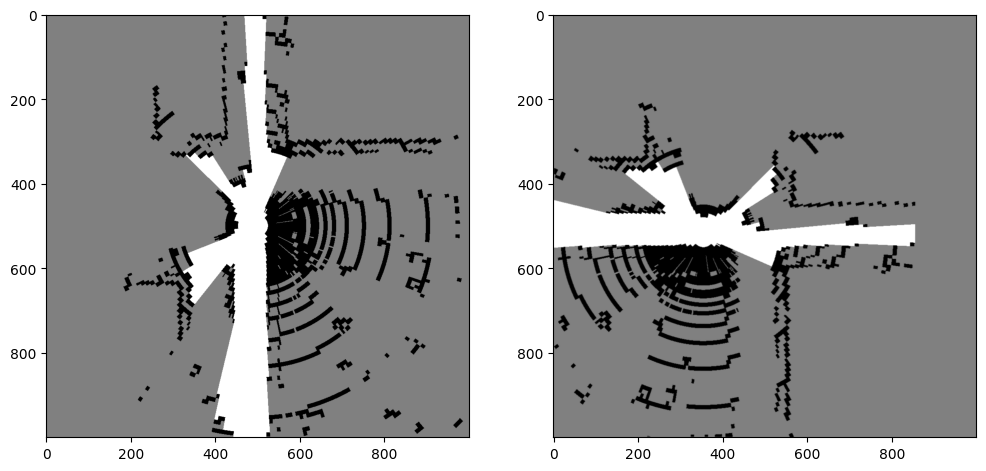

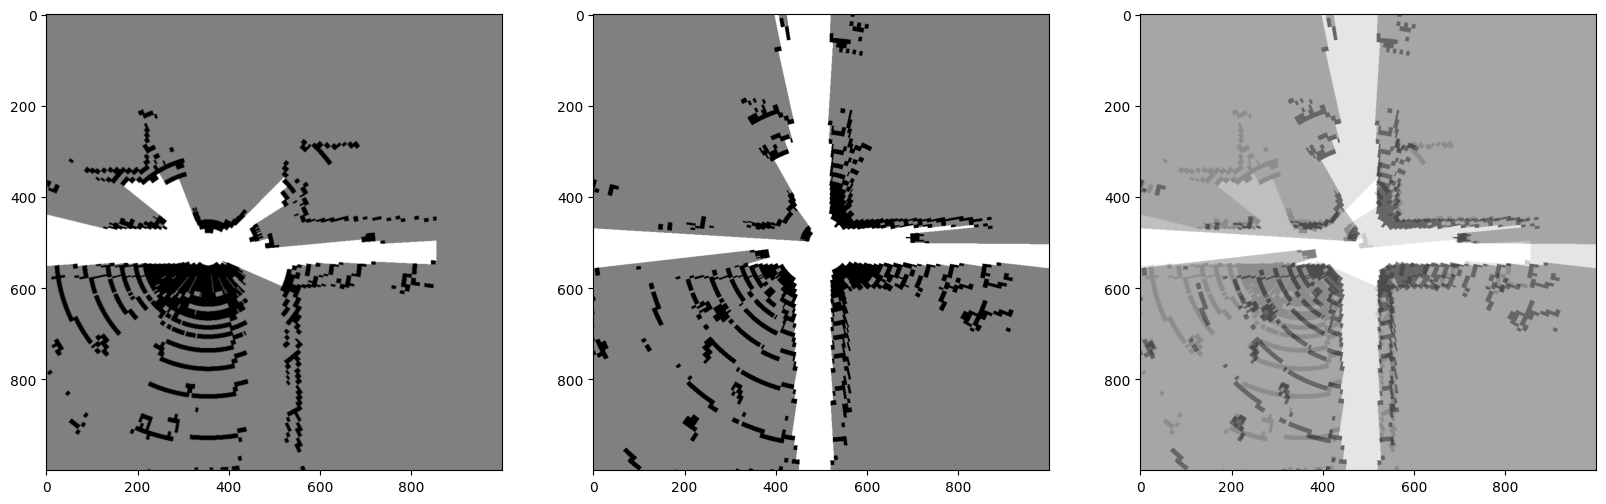

In [18]:
RESOLUTION = 0.1
# Shift the map according the vehicle's poses
def shift_pose_ogm(ogm, init, fin):
  ogm_o = ogm.copy()
  theta = -init[2]
  #theta = init[2]

  print(theta)
  rot_m = np.array([[np.cos(theta),np.sin(theta)],[-np.sin(theta),np.cos(theta)]])
  trs_m = np.array([[init[0]],[init[1]]])
  point = np.array(fin[:2]).reshape((-1,1))
  point_1 = (point - trs_m)
  print(point_1)
  point_2 = np.dot(rot_m,-point_1)


  delta_theta = (fin[2] - init[2])
  delta = np.array([point_2[1,0]/RESOLUTION,point_2[0,0]/RESOLUTION,0])
  print(delta,-delta_theta* 180 / np.pi)
  M = np.array([[1,0,delta[0]],[0,1,-delta[1]]])
  dst = cv2.warpAffine(ogm_o,M,(ogm_o.shape[1],ogm_o.shape[0]),borderValue=0.5)
  M = cv2.getRotationMatrix2D((ogm_o.shape[1]/2+0.5,ogm_o.shape[0]/2+0.5),-delta_theta* 180 / np.pi,1)
  #M = cv2.getRotationMatrix2D((ogm_o.shape[1]/2+0.5,ogm_o.shape[0]/2+0.5),delta_theta,1)
  dst = cv2.warpAffine(dst,M,(ogm_o.shape[1],ogm_o.shape[0]),borderValue=0.5)

  return dst

Ogm1_transformed = shift_pose_ogm(Ogm1,pose1,pose2)
ogm1_transformed=Ogm1_transformed[:,:,0]
fig,axs = plt.subplots(1,2,figsize=(12,6))
axs[0].imshow(((1-ogm1)*255).astype(np.uint8),cmap='gray')
axs[1].imshow(((1-ogm1_transformed)*255).astype(np.uint8),cmap='gray')

plt.show()

fig,axs = plt.subplots(1,3,figsize=(20,20))
axs[0].imshow(((1-ogm1_transformed)*255).astype(np.uint8),cmap='gray')
axs[1].imshow(((1-ogm2)*255).astype(np.uint8),cmap='gray')
axs[2].imshow(((1-ogm1_transformed)*255).astype(np.uint8),cmap='gray', alpha=0.4)
axs[2].imshow(((1-ogm2)*255).astype(np.uint8), cmap='gray', alpha=0.5)
plt.show()

In [19]:
'''yaw11=rot1[1]
yaw22=rot2[1]
pose1=np.array([loc1[0],loc1[1],yaw11])
pose2=np.array([loc2[0],loc2[1],yaw22])
RESOLUTION=0.1

# Shift the map according the vehicle's poses
def shift_pose_ogm(ogm, init, fin):
  ogm_o = ogm.copy()
  #theta = init[2]
  theta = init[2]/180 * np.pi
  print(theta)
  rot_m = np.array([[np.cos(theta),np.sin(theta)],[-np.sin(theta),np.cos(theta)]])
  trs_m = np.array([[init[0]],[init[1]]])
  point = np.array(fin[:2]).reshape((-1,1))
  point_1 = (point - trs_m)
  print(point_1)
  point_2 = np.dot(rot_m,-point_1)
  #point_2=-point_1

  delta_theta = (fin[2] - init[2])
  delta = np.array([point_2[1,0]/RESOLUTION,point_2[0,0]/RESOLUTION,0])
  print(delta,-delta_theta)
  M = np.array([[1,0,delta[0]],[0,1,-delta[1]]])
  dst = cv2.warpAffine(ogm_o,M,(ogm_o.shape[1],ogm_o.shape[0]),borderValue=0.5)
  #M = cv2.getRotationMatrix2D((ogm_o.shape[1]/2+0.5,ogm_o.shape[0]/2+0.5),-delta_theta* 180 / np.pi,1)
  M = cv2.getRotationMatrix2D((ogm_o.shape[1]/2+0.5,ogm_o.shape[0]/2+0.5),delta_theta,1)
  dst = cv2.warpAffine(dst,M,(ogm_o.shape[1],ogm_o.shape[0]),borderValue=0.5)

  return dst

ogm1_transformed = shift_pose_ogm(ogm1,pose1,pose2)

fig,axs = plt.subplots(1,2,figsize=(12,6))
axs[0].imshow(((1-ogm1)*255).astype(np.uint8),cmap='gray')
axs[1].imshow(((1-ogm1_transformed)*255).astype(np.uint8),cmap='gray')

plt.show()

fig,axs = plt.subplots(1,3,figsize=(20,20))
axs[0].imshow(((1-ogm2)*255).astype(np.uint8),cmap='gray')
axs[1].imshow(((1-ogm1_transformed)*255).astype(np.uint8),cmap='gray')
axs[2].imshow(((1-ogm1_transformed)*255).astype(np.uint8),cmap='gray', alpha=0.4)
axs[2].imshow(((1-ogm2)*255).astype(np.uint8), cmap='gray', alpha=0.5)
plt.show()'''

"yaw11=rot1[1]\nyaw22=rot2[1]\npose1=np.array([loc1[0],loc1[1],yaw11])\npose2=np.array([loc2[0],loc2[1],yaw22])\nRESOLUTION=0.1\n\n# Shift the map according the vehicle's poses\ndef shift_pose_ogm(ogm, init, fin):\n  ogm_o = ogm.copy()\n  #theta = init[2]\n  theta = init[2]/180 * np.pi\n  print(theta)\n  rot_m = np.array([[np.cos(theta),np.sin(theta)],[-np.sin(theta),np.cos(theta)]])\n  trs_m = np.array([[init[0]],[init[1]]])\n  point = np.array(fin[:2]).reshape((-1,1))\n  point_1 = (point - trs_m)\n  print(point_1)\n  point_2 = np.dot(rot_m,-point_1)\n  #point_2=-point_1\n\n  delta_theta = (fin[2] - init[2])\n  delta = np.array([point_2[1,0]/RESOLUTION,point_2[0,0]/RESOLUTION,0])\n  print(delta,-delta_theta)\n  M = np.array([[1,0,delta[0]],[0,1,-delta[1]]])\n  dst = cv2.warpAffine(ogm_o,M,(ogm_o.shape[1],ogm_o.shape[0]),borderValue=0.5)\n  #M = cv2.getRotationMatrix2D((ogm_o.shape[1]/2+0.5,ogm_o.shape[0]/2+0.5),-delta_theta* 180 / np.pi,1)\n  M = cv2.getRotationMatrix2D((ogm_o.shape[1

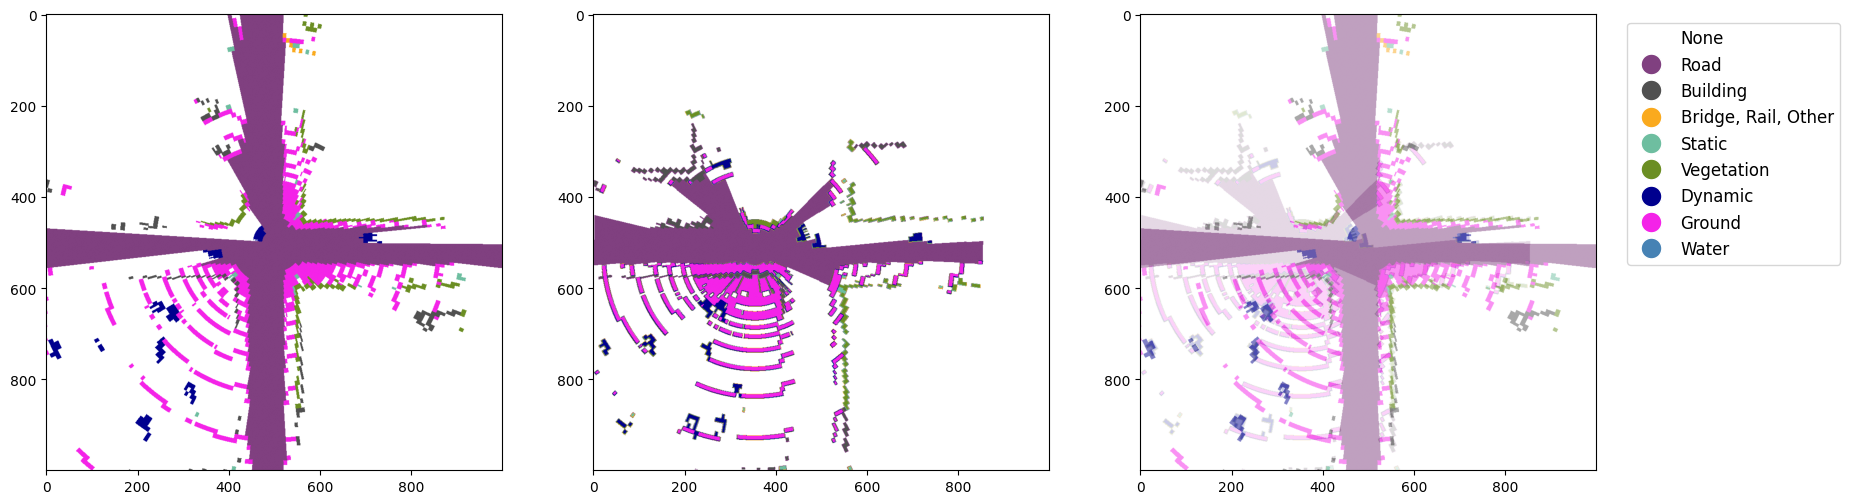

In [20]:
c1=REDUCED_LABEL_COLORS[Ogm1[:,:,1].astype(int)]
c1_transformed=REDUCED_LABEL_COLORS[Ogm1_transformed[:,:,1].astype(int)]
c2=REDUCED_LABEL_COLORS[Ogm2[:,:,1].astype(int)]
fig,axs = plt.subplots(1,3,figsize=(20,20))
axs[0].imshow(c2)
axs[1].imshow(c1_transformed)
axs[2].imshow(c1_transformed, alpha=0.4)
axs[2].imshow(c2, alpha=0.5)
axs[2].axis('scaled')
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=reduced_label_names[i], markerfacecolor=REDUCED_LABEL_COLORS[i], markersize=15) for i in range(len(reduced_label_names))]
axs[2].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='large')
plt.show()

## Update

The OGM is updated by the recent scan grid using Bayesian update. According the derivation in [4], if we initiate the OGM as empty grid, the $i$-th cell of OGM can be updated with this simple formula

\begin{align}
L_{i,t} = L_{i,t-1} + L^{SG}_{i,t-1}
\end{align}

$L_{i,t}$ is the [logit](https://en.wikipedia.org/wiki/Logit) of the $i$-th cell of the updated OGM.

$L_{i,t-1}$ is the logit of the $i$-th cell of the previous OGM.

$L^{SG}_{i,t-1}$ is the logit of the $i$-th cell of the scan grid that are generated from the latest LiDAR points.

Then, the usable OGM can be found by calculating the inverse-logit of $L_{i,t}$

<ipython-input-21-768d9e3a9f0e>:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.log(np.divide(m, np.subtract(1, m)))
<ipython-input-21-768d9e3a9f0e>:3: RuntimeWarning: divide by zero encountered in log
  return np.log(np.divide(m, np.subtract(1, m)))
<ipython-input-21-768d9e3a9f0e>:3: RuntimeWarning: invalid value encountered in log
  return np.log(np.divide(m, np.subtract(1, m)))
<ipython-input-21-768d9e3a9f0e>:11: RuntimeWarning: invalid value encountered in add
  logit_map = logit(new_ogm) + logit(prior_ogm)
<ipython-input-21-768d9e3a9f0e>:7: RuntimeWarning: invalid value encountered in true_divide
  return np.divide(np.exp(m),np.add(1,np.exp(m)))


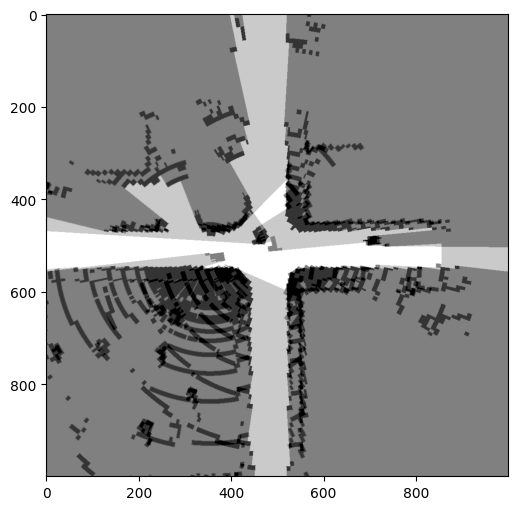

In [21]:
### Calculate the logit function
def logit(m):
  return np.log(np.divide(m, np.subtract(1, m)))

### Calculate the inverse logit function
def inverse_logit(m):
  return np.divide(np.exp(m),np.add(1,np.exp(m)))

### Update the prior OGM with the scan grid (new_ogm)
def update_ogm(prior_ogm,new_ogm):
  logit_map = logit(new_ogm) + logit(prior_ogm)
  out_ogm = inverse_logit(logit_map)
  out_ogm[out_ogm>=0.98] = 0.98
  out_ogm[out_ogm<=0.02] = 0.02
  return out_ogm

Ogm_sup = update_ogm(Ogm1_transformed,Ogm2)

### Visualize
fig,axs = plt.subplots(1,1,figsize=(6,6))
axs.imshow(((1-Ogm_sup[:,:,0])*255).astype(np.uint8),cmap='gray')
plt.show()

# MAPPING (DGM)

In OGM, it is hard to tell which one among the detected obstacles are dynamic objects. Many imporvements have been done to make the OGM can store the information of dynamics object, which leads to a new type of grid map: Dynamic Grid Map (DGM). One simple approach that can be used to generate DGM is by using Dempster-Shafer Theory (DST), also known as evidential theory, to estimate the map instead of using probabilistic Bayesian theory. We implement one based on [5].

In DST-based grid map, each cell's state is stored in form of a mass function $m$. This mass function consists of $m(\{F\}),m(\{O\}),m(\{F,O\}),m(\emptyset)$ that represent evidence that the cell is free, occupied, unknown, or conflicting respectively. The update algorithm for DST-based grid map is performed by using the Dempster's combination rule. In short, the conflicting evidence, which comes up when there are inconsistent measurements at the cell as time passed, may indicate that the cell is occupied by a dynamic object.

For more details, please take a look at [5].

## load lidar data

In [22]:
lidar1=folder_path1+'/Lidar'
lidar2=folder_path2+'/Lidar'
data1=np.load(lidar1+'/{}.npy'.format(date))
data2=np.load(lidar2+'/{}.npy'.format(date))
lidar_raw1=data1.reshape(-1, 6)
lidar_raw2=data2.reshape(-1, 6)

lidar_raw1 = lidar_raw1[lidar_raw1[:, 2] <= 0, :]
lidar_raw2 = lidar_raw2[lidar_raw2[:, 2] <= 0, :]
# Define the radius (in meters)
radius = 2.7
# Calculate the Euclidean distance between each point in the point cloud and the lidar sensor position
distances1 = np.sqrt((lidar_raw1[:, 0])**2 + (lidar_raw1[:, 1])**2)
distances2 = np.sqrt((lidar_raw2[:, 0])**2 + (lidar_raw2[:, 1])**2)
# Filter out all the points that are within the radius of the lidar sensor position
lidar_raw1 = lidar_raw1[distances1 > radius, :]
lidar_raw2 = lidar_raw2[distances2 > radius, :]

labels1=np.array(lidar_raw1[:, 5]).astype(int)
labels2=np.array(lidar_raw2[:, 5]).astype(int)
lidar_labeled1=np.array(lidar_raw1[..., [0, 1, 2, 5]])
lidar_labeled2=np.array(lidar_raw2[..., [0, 1, 2, 5]])
lidar_raw1 = lidar_raw1[:, :3]
lidar_raw2 = lidar_raw2[:, :3]

road_filter1=np.zeros_like(labels1)
road_filter1[(labels1 == 0) | (labels1 == 7) | (labels1 == 6)] = 1

road_filter2=np.zeros_like(labels2)
road_filter2[(labels2 == 0) | (labels2 == 7) | (labels2 == 6)] = 1

def filter_road_points(lidar_in, is_road, threshold=0.5):
  y_true = lidar_in[:,1]
  y = np.zeros_like(y_true)

  y = y_true * is_road  # set road points' predicted height to true height
  delta_y = np.absolute(y_true-y).flatten()
  is_not_road = delta_y > threshold
  lidar_out = lidar_in[is_not_road,:].copy()
  return lidar_out





lidar_nonroad1 = filter_road_points(lidar_raw1,road_filter1,0.1)
lidar_nonroad2 = filter_road_points(lidar_raw2,road_filter2,0.1)


## Parameters

The parameters mostly similar with OGM, but with addition:
- FREE_CONF = Our confidence level [0,1] in the results that are categorized as free.
- OCC_CONF = Our confidence level [0,1] in the results that are categorized as occupied.
- DYNAMIC_THRESHOLD = The minimal value of $m(\emptyset)$ to categorize a cell as occupied by dynamic object.



In [23]:
ALPHA = 1
BHETA = 1*np.pi/180
RESOLUTION = 0.1

MAX_RANGE = 50
MAP_WIDTH = 100
SPHERICAL2CARTESIAN_BIAS = 6
FREE_CONF = 0.7
OCC_CONF = 0.7
DYNAMIC_THRESHOLD = 0.4

## Map Initialization

The OGM is initialized with mass function of all of its cells, $m(\{F\})=0,m(\{O\})=0,m(\{F,O\})=1,m(\emptyset)=0$.

This means that we still don't have any information about the occupancy of the cells.

In [24]:
MAP_SIZE_X = int(MAP_WIDTH/RESOLUTION)
MAP_SIZE_Y = int(MAP_WIDTH/RESOLUTION)
xarr = np.arange(-MAP_WIDTH/2,MAP_WIDTH/2,RESOLUTION)
yarr = np.arange(-MAP_WIDTH/2,MAP_WIDTH/2,RESOLUTION)
MAP_XX, MAP_YY = np.meshgrid(xarr, -yarr)
rgrid = np.sqrt(np.add(np.square(MAP_XX),np.square(MAP_YY)))
OOR_MASK = rgrid >= MAX_RANGE

'''
DGM Channel:
Channel 0 = {F,O}
Channel 1 = O
Channel 2 = F
'''
dgm_time_0 = np.zeros((MAP_SIZE_Y,MAP_SIZE_X,3))
dgm_time_0[:,:,0] = 1

lidar_dgm1 = lidar_nonroad1[:,[0,1]]
lidar_dgm2 = lidar_nonroad2[:,[0,1]]

## Generate Measurement Grid from Filtered LiDAR

The overall process of scan grid generation is the same as in OGM. The only difference is how we fill the cells according to condition 1, 2, and 3 (refer to the image in OGM measurement grid generation code). Cell under condition:

1. (Black cells/likely to be occupied) - are given mass function

\begin{align}m(\{F\})=0, m(\{O\})=OCC\_CONF, m(\{F,O\})=1-OCC\_CONF\end{align}

2. (White cells/likely to be free) - are given mass function

\begin{align}m(\{F\})=FREE\_CONF, m(\{O\})=0, m(\{F,O\})=1-FREE\_CONF\end{align}

3. (Gray cells/unknown) - are given mass function

\begin{align}m(\{F\})=0, m(\{O\})=0, m(\{F,O\})=1\end{align}

The value of $m(\emptyset)$ is 0 and should always be 0, according to DST. We only use $m(\emptyset)$ to detect dynamic cells at an instant time.


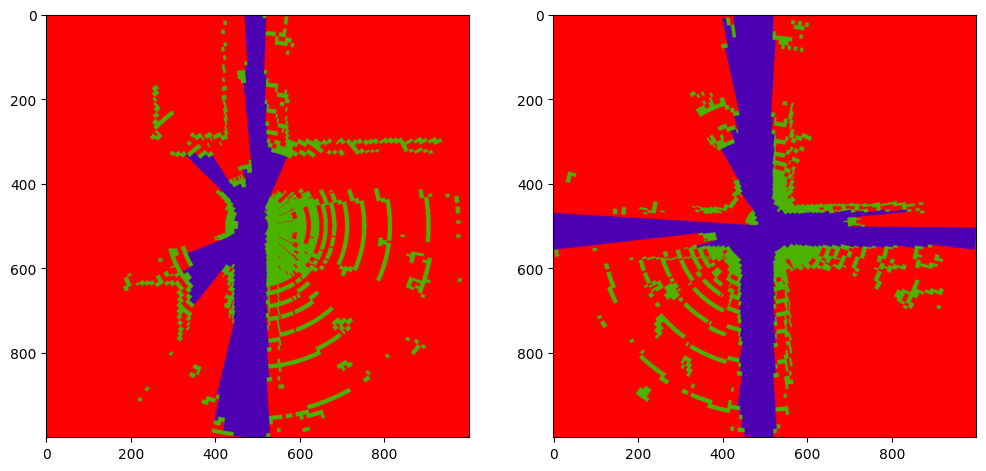

In [25]:
def generate_measurement_dgm(lidar_in,dgm_shape):
  ### Calculate the position of LiDAR points in spherical coordinate
  rphi_meas = np.zeros((lidar_in.shape[0],2))
  rphi_meas[:,1] = np.sqrt(np.add(np.square(lidar_in[:,0]),np.square(lidar_in[:,1])))/ALPHA
  rphi_meas[:,0] = (np.arctan2(lidar_in[:,1],lidar_in[:,0])+np.pi)/BHETA
  rphi_meas = np.unique(rphi_meas.astype(int),axis=0)
  rphi_meas = rphi_meas[rphi_meas[:,1]<int(MAX_RANGE/ALPHA),:]
  rphi_meas = rphi_meas[rphi_meas[:,0]<int(2*np.pi/BHETA),:]

  ### Initiate and fill the spherical scan grid
  sg_ang_bin = int(2*np.pi/BHETA)
  sg_rng_bin = int(MAX_RANGE/ALPHA)
  scan_grid = np.zeros((sg_ang_bin,sg_rng_bin,3))
  scan_grid[:,:,0] = 1
  scan_grid[tuple(rphi_meas.T)] = (1-OCC_CONF,OCC_CONF,0)
  for ang in range(sg_ang_bin):
    ang_arr = rphi_meas[rphi_meas[:,0]==ang,1]
    if len(ang_arr) == 0:
      scan_grid[ang,:] = (1-FREE_CONF,0,FREE_CONF)
    else:
      min_r = np.min(ang_arr)
      scan_grid[ang,:min_r] = (1-FREE_CONF,0,FREE_CONF)

  ### Convert the spherical scan grid to the cartesian one
  dgm_sz = (dgm_shape[1],dgm_shape[0])
  dgm_cen = (int(dgm_shape[1]/2),int(dgm_shape[0]/2))
  radius = (MAX_RANGE/RESOLUTION) + SPHERICAL2CARTESIAN_BIAS
  dgm_step = cv2.warpPolar(scan_grid,dgm_sz,dgm_cen,radius,cv2.WARP_INVERSE_MAP)
  dgm_step[OOR_MASK] = (1,0,0)
  dgm_step = cv2.rotate(dgm_step, cv2.ROTATE_90_CLOCKWISE)
  return dgm_step

dgm1 = generate_measurement_dgm(lidar_dgm1,dgm_time_0.shape)
dgm2 = generate_measurement_dgm(lidar_dgm2,dgm_time_0.shape)

### Visualize
fig,axs = plt.subplots(1,2,figsize=(12,6))
axs[0].imshow((dgm1*255).astype(np.uint8))
axs[1].imshow((dgm2*255).astype(np.uint8))
plt.show()

In [26]:
print(dgm1[500,500])

[0.3 0.  0.7]


## Try First Update

The update of DGM is done with Dempster's rule of combination. By theory, to combine two mass functions $m_1$ and $m_2$ into a new mass function $m_{1,2}$, the following formula is used

\begin{align}
m_{1,2}(A)=\frac{1}{1-K}\sum_{B\cap C=A\neq\emptyset} m_1(B).m_2(C)
\end{align}

\begin{align}
m(\emptyset) = 0
\end{align}

\begin{align}
K=\sum_{B\cap C=\emptyset} m_1(B).m_2(C)
\end{align}

Note that te sum of all evindeces in a mass function must be equal to 1. If we apply it to the DGM case, the combination rule will be

\begin{align}
m_{1,2}(\{F\})=\frac{1}{1-K}(m_1(\{F\}).m_2(\{F,O\}) + m_1(\{F,O\}).m_2(\{F\}))
\end{align}

\begin{align}
m_{1,2}(\{O\})=\frac{1}{1-K}(m_1(\{O\}).m_2(\{F,O\}) + m_1(\{F,O\}).m_2(\{O\}))
\end{align}

\begin{align}
m_{1,2}(\{F,O\})=\frac{1}{1-K}(m_1(\{F,O\}).m_2(\{F,O\}))
\end{align}

\begin{align}
m_{1,2}(\emptyset) = 0
\end{align}

\begin{align}
K=m_1(\{O\}).m_2(\{F\}) + m_1(\{F\}).m_2(\{O\}))
\end{align}

with $m_t$ is the mass function of previous DGM, $m^{SG}_t$ is the scan grid ofthe current LiDAR measurement and $m_{t+1}$ is the updated DGM mass function.The conflicting evidence is actually calculated as $K$. But because the DST only allow $m(\emptyset)$ to be 0, this factor is used as normalization factor for others.

To categorize the cells, we only need to find the maximum mass in its mass function. For example, if the maximum mass is $F$, it will be categorized as free cell. But, cells that have $K>DYNAMIC\_THRESHOLD$ will be classified as dynamic cells.


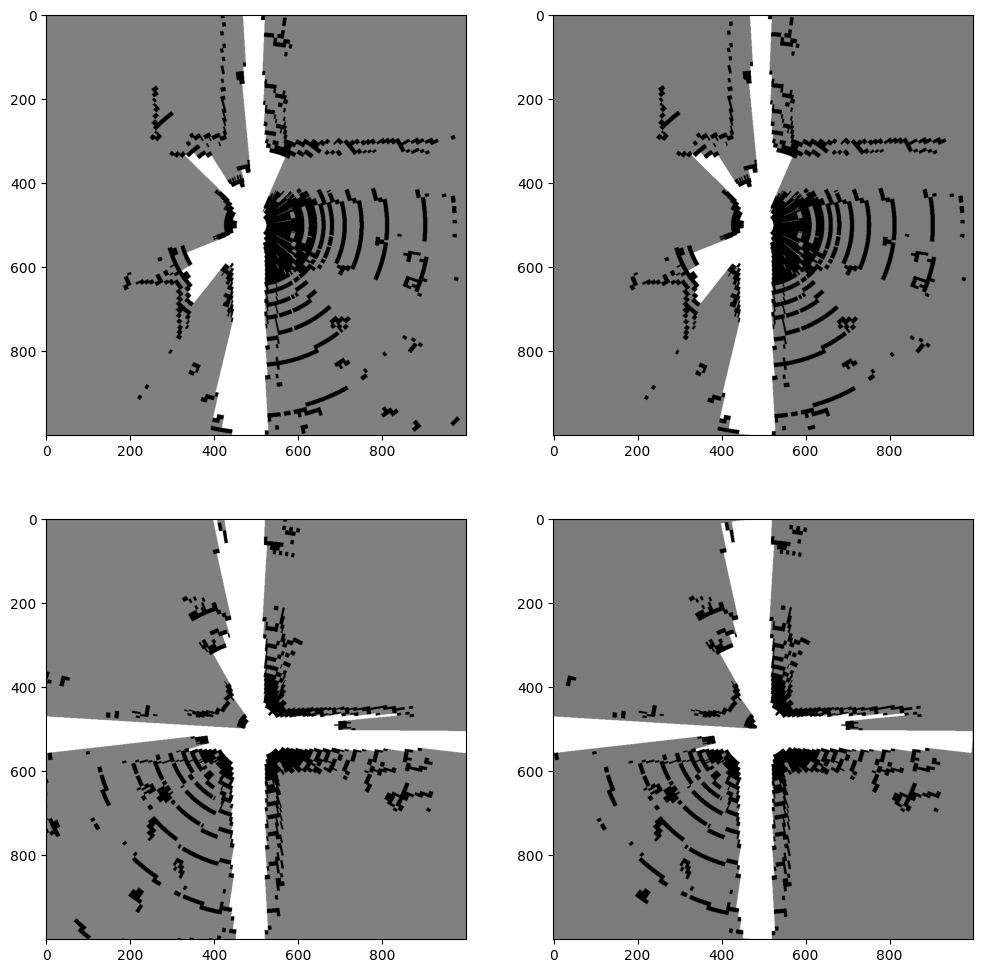

In [27]:
### Update the DGM with DST rule of combination
def update_dgm(prior_dgm,new_dgm):
  ### Calculate conflicting mass
  conflict_mass = np.multiply(prior_dgm[:,:,2],new_dgm[:,:,1])
  conflict_mass = np.add(conflict_mass,np.multiply(prior_dgm[:,:,1],new_dgm[:,:,2]))

  ### Calculate free mass
  free_mass = np.multiply(prior_dgm[:,:,0],new_dgm[:,:,2])
  free_mass = np.add(free_mass,np.multiply(prior_dgm[:,:,2],new_dgm[:,:,0]))
  free_mass = np.add(free_mass,np.multiply(prior_dgm[:,:,2],new_dgm[:,:,2]))
  free_mass = np.divide(free_mass,1-conflict_mass)

  ### Calculate occupied mass
  occ_mass = np.multiply(prior_dgm[:,:,0],new_dgm[:,:,1])
  occ_mass = np.add(occ_mass,np.multiply(prior_dgm[:,:,1],new_dgm[:,:,0]))
  occ_mass = np.add(occ_mass,np.multiply(prior_dgm[:,:,1],new_dgm[:,:,1]))
  occ_mass = np.divide(occ_mass,1-conflict_mass)

  ### Calculate unknown mass
  unknown_mass = np.multiply(prior_dgm[:,:,0],new_dgm[:,:,0])
  unknown_mass = np.divide(unknown_mass,1-conflict_mass)

  updated_dgm = np.stack((unknown_mass,occ_mass,free_mass),axis=2)
  return updated_dgm,conflict_mass

### Convert the DGM to a displayable figure
def predict_dgm(dgm,dynamic_mass,dt=DYNAMIC_THRESHOLD):
  max_mass = np.argmax(dgm,axis=2)
  pred_map = np.zeros(dgm.shape)
  # The unknown cells: gray
  pred_map[max_mass==0] = (123,123,123)
  # The occupied cells: black
  pred_map[max_mass==1] = (0,0,0)
  # The free cells: white
  pred_map[max_mass==2] = (255,255,255)
  # The dynamic cells: blue
  pred_map[dynamic_mass>=dt] = (0,0,255)
  return pred_map.astype(np.uint8)

dgm_time_1,dynamic_mass_1 = update_dgm(dgm_time_0,dgm1)
dgm_pred_1 = predict_dgm(dgm_time_1,dynamic_mass_1)
dgm_time_2,dynamic_mass_2 = update_dgm(dgm_time_0,dgm2)
dgm_pred_2 = predict_dgm(dgm_time_2,dynamic_mass_2)

fig,axs = plt.subplots(2,2,figsize=(12,12))
axs[0,0].imshow(((1-ogm1)*255).astype(np.uint8),cmap='gray')
axs[0,1].imshow(dgm_pred_1)
axs[1,0].imshow(((1-ogm2)*255).astype(np.uint8),cmap='gray')
axs[1,1].imshow(dgm_pred_2)

plt.show()

## Shift the DGM

Shift the OGM with the same way as with OGM

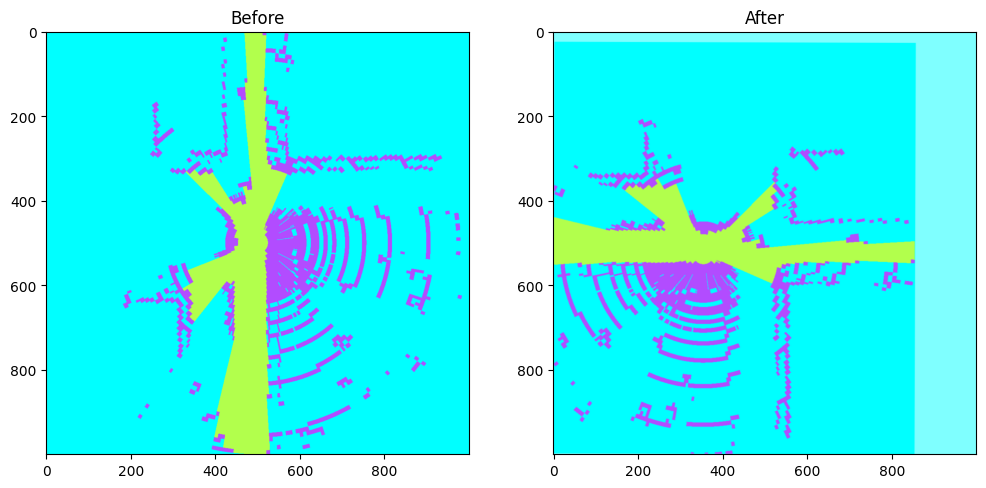

In [28]:
#RESOLUTION=RESOLUTION -25
# Shift the map according the vehicle's poses
def shift_pose_dgm(dgm, init, fin):
  dgm_o = dgm.copy()
  #theta = init[2] /180 * np.pi
  theta = -init[2]
  rot_m = np.array([[np.cos(theta),np.sin(theta)],[-np.sin(theta),np.cos(theta)]])
  trs_m = np.array([[init[0]],[init[1]]])
  point = np.array(fin[:2]).reshape((-1,1))
  point_1 = (point - trs_m)
  point_2 = np.dot(rot_m,-point_1)
  delta_theta = (fin[2] - init[2])
  delta = np.array([point_2[1,0]/RESOLUTION,point_2[0,0]/RESOLUTION,0])

  M = np.array([[1,0,delta[0]],[0,1,-delta[1]]])
  dst = cv2.warpAffine(dgm_o,M,(dgm_o.shape[1],dgm_o.shape[0]),borderValue=0.5)
  M = cv2.getRotationMatrix2D((dgm_o.shape[1]/2+0.5,dgm_o.shape[0]/2+0.5),-delta_theta* 180 / np.pi,1)
  #M = cv2.getRotationMatrix2D((dgm_o.shape[1]/2+0.5,dgm_o.shape[0]/2+0.5),delta_theta,1)
  dst = cv2.warpAffine(dst,M,(dgm_o.shape[1],dgm_o.shape[0]),borderValue=0.5)
  return dst

shift_dgm_time_1 = shift_pose_dgm(dgm_time_1,pose1,pose2)

### Visualize
fig,axs = plt.subplots(1,2,figsize=(12,6))
axs[0].imshow(((1-dgm_time_1)*255).astype(np.uint8),cmap='gray')
axs[0].set_title('Before')
axs[1].imshow(((1-shift_dgm_time_1)*255).astype(np.uint8),cmap='gray')
axs[1].set_title('After')
plt.show()

## The Second Update

Let's update the map again!

The dynamic cells are colored blue.

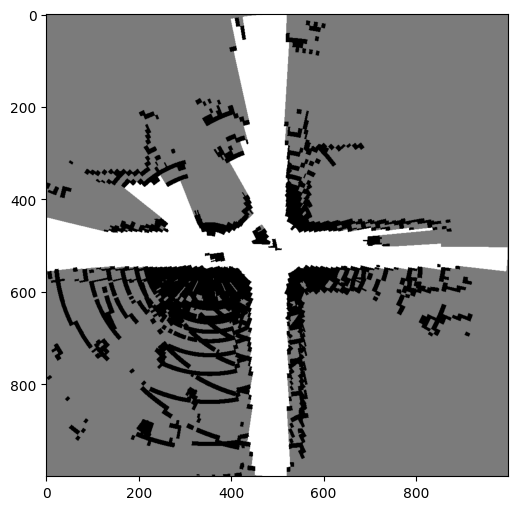

In [29]:
dgm_fuse,dynamic_mass_fuse = update_dgm(shift_dgm_time_1,dgm_time_2)
dgm_pred_fuse = predict_dgm(dgm_fuse,dynamic_mass_fuse,10)

fig,axs = plt.subplots(1,1,figsize=(6,6))
axs.imshow(dgm_pred_fuse)
plt.show()

In [30]:
print(dgm_pred_fuse[500,500])
print(dgm_fuse[500,500])

[255 255 255]
[0.28205128 0.05982906 0.65811966]


# MAPPING (SGM)


## load lidar data

In [31]:
reduced_labels2=np.zeros_like(labels2)
reduced_labels2[(labels2 == 7) | (labels2 == 6)] = 1
reduced_labels2[(labels2 == 1)| (labels2 == 2) | (labels2 == 11) | (labels2 == 19)] = 2
reduced_labels2[(labels2 == 3)| (labels2 == 15) | (labels2 == 17) | (labels2 == 18)] = 3
reduced_labels2[(labels2 == 5)| (labels2 == 18) | (labels2 == 19)] = 4
reduced_labels2[(labels2 == 9)] = 5
reduced_labels2[(labels2 == 4)| (labels2 == 10) | (labels2 == 20)] = 6
reduced_labels2[(labels2 == 8)| (labels2 == 14) | (labels2 == 22)] = 7
reduced_labels2[(labels2 == 21)] = 8

reduced_color2 = REDUCED_LABEL_COLORS[reduced_labels2]
lidar_rlabeled2 = np.concatenate((lidar_raw2, reduced_labels2[..., np.newaxis]), axis=-1)





reduced_labels1=np.zeros_like(labels1)
reduced_labels1[(labels1 == 7) | (labels1 == 6)] = 1
reduced_labels1[(labels1 == 1)| (labels1 == 2) | (labels1 == 11) | (labels1 == 19)] = 2
reduced_labels1[(labels1 == 3)| (labels1 == 15) | (labels1 == 17) | (labels1 == 18)] = 3
reduced_labels1[(labels1 == 5)| (labels1 == 18) | (labels1 == 19)] = 4
reduced_labels1[(labels1 == 9)] = 5
reduced_labels1[(labels1 == 4)| (labels1 == 10) | (labels1 == 20)] = 6
reduced_labels1[(labels1 == 8)| (labels1 == 14) | (labels1 == 22)] = 7
reduced_labels1[(labels1 == 21)] = 8

reduced_color1 = REDUCED_LABEL_COLORS[reduced_labels1]
lidar_rlabeled1 = np.concatenate((lidar_raw1, reduced_labels1[..., np.newaxis]), axis=-1)

In [32]:

lidar_nonroad_rlabeled1 = filter_road_points(lidar_rlabeled1,road_filter1,0.1)
lidar_nonroad_rlabeled2 = filter_road_points(lidar_rlabeled2,road_filter2,0.1)


## Parameters

In [33]:
ALPHA = 1
BHETA = 1*np.pi/180
RESOLUTION = 0.1

MAX_RANGE = 100
MAP_WIDTH = 100
SPHERICAL2CARTESIAN_BIAS = 6


DYNAMIC_THRESHOLD = 0.4

## Map Initialization

$m(\{C_1\}),...,m(\{C_i\}),m(\{C_1,..,C_i\}),m(\emptyset)$.

In [34]:
MAP_SIZE_X = int(MAP_WIDTH/RESOLUTION)
MAP_SIZE_Y = int(MAP_WIDTH/RESOLUTION)
xarr = np.arange(-MAP_WIDTH/2,MAP_WIDTH/2,RESOLUTION)
yarr = np.arange(-MAP_WIDTH/2,MAP_WIDTH/2,RESOLUTION)
MAP_XX, MAP_YY = np.meshgrid(xarr, -yarr)
rgrid = np.sqrt(np.add(np.square(MAP_XX),np.square(MAP_YY)))
OOR_MASK = rgrid >= MAX_RANGE

'''
DGM Channel:
Channel 0 = {F,O}
Channel 1 = O
Channel 2 = F
'''
num_classes=REDUCED_LABEL_COLORS.shape[0]
print(num_classes)
dgm_time_0 = np.zeros((MAP_SIZE_Y,MAP_SIZE_X,num_classes))
dgm_time_0[:,:,0] = 1

lidar_dgm1 = lidar_nonroad_rlabeled1[:,[0,1,3]]
lidar_dgm2 = lidar_nonroad_rlabeled2[:,[0,1,3]]

9


In [35]:
dgm_time_0.shape

(1000, 1000, 9)

## Generate Measurement Grid from Filtered LiDAR


For cells labeled with a specific object class\\

m['Class1'] = L1_CONF \\
m['Class2'] = L2_CONF \\
m['Class3'] = L3_CONF \\
m['Class4'] = L4_CONF \\
m['Class5'] = L5_CONF \\
m['Class6'] = L6_CONF \\
m['Class7'] = L7_CONF \\
m['Class8'] = L8_CONF \\
m['Class0'] = 1 - (L1_CONF + L2_CONF + L3_CONF + L4_CONF + L5_CONF + L6_CONF + L7_CONF + L8_CONF) \\

For cells not labeled with any of the specific object classes \\

m['Class1'] = 0 \\
m['Class2'] = 0 \\
m['Class3'] = 0 \\
m['Class4'] = 0 \\
m['Class5'] = 0 \\
m['Class6'] = 0 \\
m['Class7'] = 0 \\
m['Class8'] = 0 \\
m['Class0'] = 1 \\

In [36]:
REDUCED_LABEL_COLORS = np.array([
    (255, 255, 255), # None
    (128, 64, 128),  # Road RoadLines
    (80, 80, 80),    # Building,Wall, static ,Fences
    (250, 170, 30),    # Other ,GuardRail ,RailTrack ,15Bridge
    (110, 190, 160), # Pole ;TrafficLight; Static
    (107, 142, 35),  # Vegetation
    (0, 0, 142),     # Vehicle Dynamic pedestrians
    (244, 35, 232),  # Sidewalk Ground Terrain
    (70, 130, 180),   # Water

]) / 255.0 # normalize each channel [0-1] since is what Open3D uses

[0 1 2 4 5 6 7]


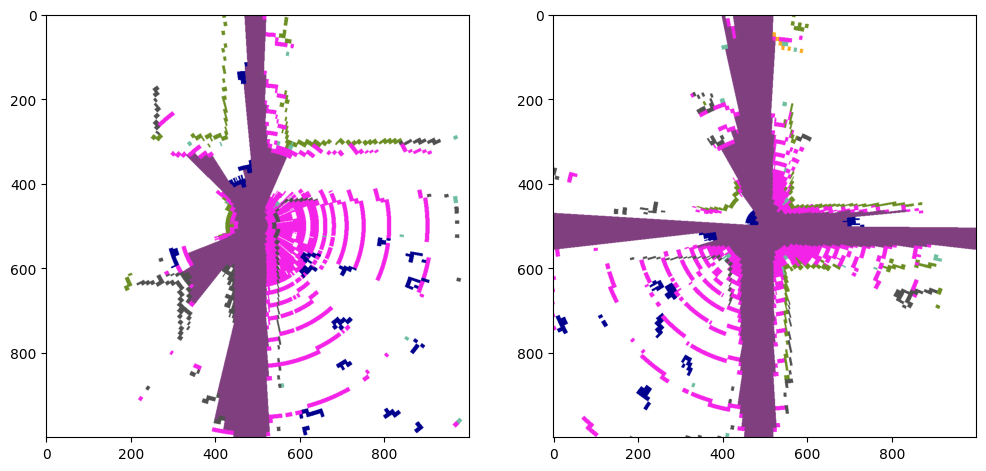

In [37]:
L0_CONF = 0.1
L1_CONF = 0.8
L2_CONF = 1
L3_CONF = 1
L4_CONF = 1
L5_CONF = 1
L6_CONF = 1
L7_CONF = 1
L8_CONF = 1



class_conf={
    0 : L0_CONF,
    1 : L1_CONF,
    2 : L2_CONF,
    3 : L3_CONF,
    4 : L4_CONF,
    5 : L5_CONF,
    6 : L6_CONF,
    7 : L7_CONF,
    8 : L8_CONF}



def generate_semantic_dgm(lidar_in, ogm_shape):
  ### Calculate the position of LiDAR points in spherical coordinate
    rphi_meas = np.zeros((lidar_in.shape[0], 3))
    rphi_meas[:, 1] = np.sqrt(np.add(np.square(lidar_in[:, 0]), np.square(lidar_in[:, 1]))) / ALPHA
    rphi_meas[:, 0] = (np.arctan2(lidar_in[:, 1], lidar_in[:, 0]) + np.pi) / BHETA
    rphi_meas[:, 2]=lidar_in[:,2]


    rphi_meas = np.unique(rphi_meas.astype(int), axis=0)

    rphi_meas = rphi_meas[rphi_meas[:, 1] < int(MAX_RANGE / ALPHA), :]
    rphi_meas = rphi_meas[rphi_meas[:, 0] < int(2 * np.pi / BHETA), :]

    ### Initiate and fill the spherical scan grid
    sg_ang_bin = int(2 * np.pi / BHETA)
    sg_rng_bin = int(MAX_RANGE / ALPHA)
    # Initiation (Condition 3)

    label_grid_np = np.zeros((sg_ang_bin, sg_rng_bin,num_classes))
    label_grid_np[:,:,0] = 1
    label_grid = [[[] for _ in range(sg_rng_bin)] for _ in range(sg_ang_bin)]

    # Condition 1

    for i in range(rphi_meas.shape[0]):

      ang = rphi_meas[i, 0]
      rng = rphi_meas[i, 1]
      label = rphi_meas[i, 2]
      #label_grid[int(ang), int(rng)] = label
      label_grid[ang][rng].append(label)

    # Assign majority label to each cell
    for ang in range(sg_ang_bin):
        for rng in range(sg_rng_bin):
            cell_labels = label_grid[ang][rng]

            # Exclude label 0 from the list of cell_labels
            #cell_labels = [label for label in cell_labels if label != 0]


            if len(cell_labels) > 0:
                # Count the occurrences of each label
                  label_counts = Counter(cell_labels)
                  label_counts = {label: label_counts[label] * class_conf.get(label, 1) for label in label_counts}
                  total_count = sum(label_counts.values())

                  # Calculate the appearance percentage for each label in cell_labels
                  appearance_percentages = {label: count / total_count for label, count in label_counts.items()}

                  # Fill in the remaining labels in label_counts with 0 counts
                  for label in range(num_classes):
                      if label not in label_counts:
                          label_counts[label] = 0

                  appearance_tuple = tuple(appearance_percentages.get(label, 0) for label in range(num_classes))
                  #print(appearance_tuple)
                  # Assign the appearance tuple to the grid cell
                  label_grid_np[ang][rng] = appearance_tuple
            else:

              label_grid_np[ang][rng] = (1,0,0,0,0,0,0,0,0)

    for ang in range(sg_ang_bin):
        ang_arr = rphi_meas[rphi_meas[:, 0] == ang, 1]

        if len(ang_arr) == 0:

            label_grid_np[ang, :] = (0.2,0.8,0,0,0,0,0,0,0)
        else:

            min_r = np.min(ang_arr)

            label_grid_np[ang, :(min_r)] = (0.2,0.8,0,0,0,0,0,0,0)



    ### Convert the spherical scan grid to the cartesian one
    ogm_sz = (ogm_shape[1], ogm_shape[0])
    ogm_cen = (int(ogm_shape[1] / 2), int(ogm_shape[0] / 2))
    radius = (MAX_RANGE / RESOLUTION) + SPHERICAL2CARTESIAN_BIAS

    label_step = cv2.warpPolar(label_grid_np, ogm_sz, ogm_cen, radius, cv2.WARP_INVERSE_MAP)

    label_step[OOR_MASK] = (1,0,0,0,0,0,0,0,0)
    for i in range(label_step.shape[-1]):
        label_step[:, :, i] = cv2.rotate(label_step[:, :, i], cv2.ROTATE_90_CLOCKWISE)
    #label_step = cv2.rotate(label_step, cv2.ROTATE_90_CLOCKWISE)


    return label_step




sdgm_step = generate_semantic_dgm(lidar_rlabeled1[:,[0,1,3]],dgm_time_0.shape)
c=REDUCED_LABEL_COLORS[sdgm_step.astype(int)]

### Visualize
sgm1 = generate_semantic_dgm(lidar_dgm1,dgm_time_0.shape)
sgm2 = generate_semantic_dgm(lidar_dgm2,dgm_time_0.shape)

### Visualize

fig,axs = plt.subplots(1,2,figsize=(12,6))
print(np.unique(np.argmax(sgm1,axis=2)))
axs[0].imshow(REDUCED_LABEL_COLORS[np.argmax(sgm1,axis=2).astype(int)])
axs[1].imshow(REDUCED_LABEL_COLORS[np.argmax(sgm2,axis=2).astype(int)])
plt.show()

In [38]:

print(sgm1[100,500])
print(np.unique(sgm1))
print(sgm1.shape)


[0.2 0.8 0.  0.  0.  0.  0.  0.  0. ]
[0.         0.2        0.33333333 0.5        0.8        1.        ]
(1000, 1000, 9)


## Try First Update

The update of DGM is done with Dempster's rule of combination. By theory, to combine two mass functions $m_1$ and $m_2$ into a new mass function $m_{1,2}$, the following formula is used

\begin{align}
m_{1,2}(A)=\frac{1}{1-K}\sum_{B\cap C=A\neq\emptyset} m_1(B).m_2(C)
\end{align}

\begin{align}
m(\emptyset) = 0
\end{align}

\begin{align}
K=\sum_{B\cap C=\emptyset} m_1(B).m_2(C)
\end{align}


for combinig the functions using Yager's rule, the following formula is used

\begin{align}
m_{1,2}(A)=\sum_{B\cap C=A\neq\emptyset} m_1(B).m_2(C)\  +K
\end{align}

\begin{align}
m(\emptyset) = 0
\end{align}

\begin{align}
K=\sum_{B\cap C=\emptyset} m_1(B).m_2(C)
\end{align}




Note that te sum of all evindeces in a mass function must be equal to 1.

[0 1 2 4 5 6 7]
[0 1 2 3 4 5 6 7]


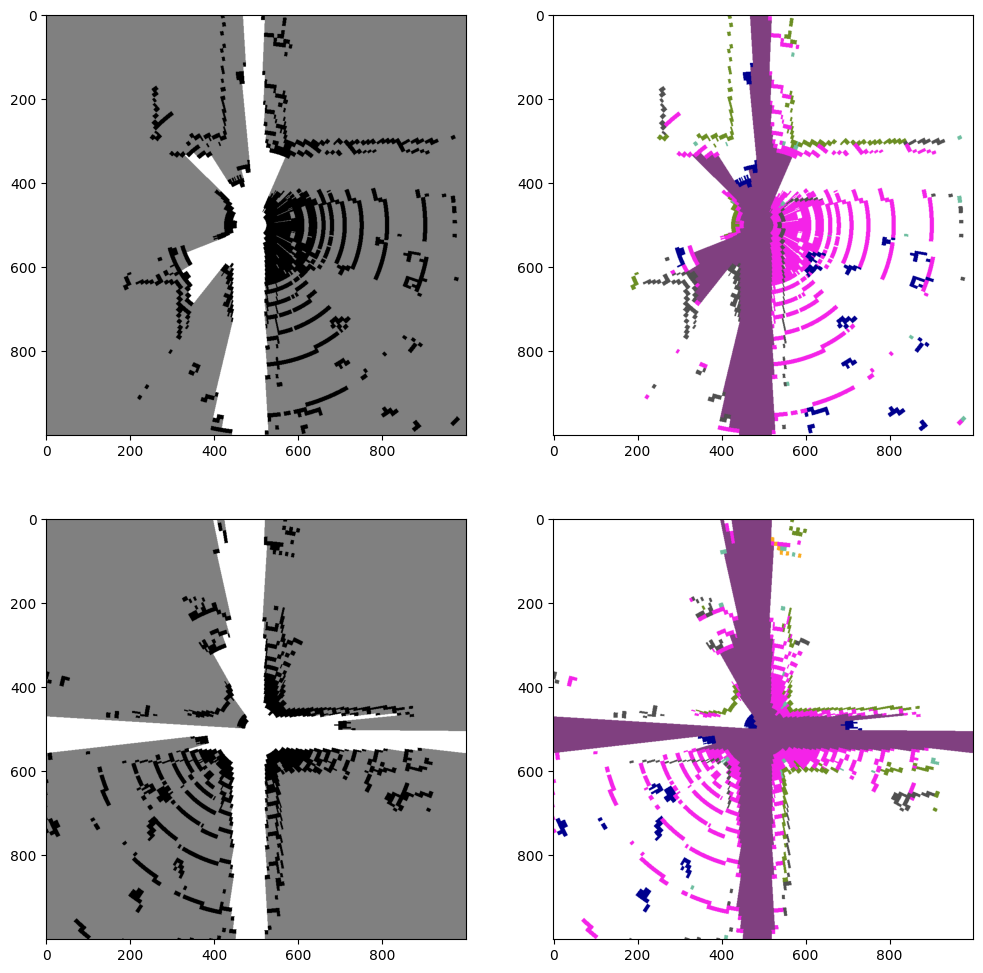

In [39]:
import numpy as np

# Update the DGM with DST rule of combination
def update_dgm(prior_dgm, new_dgm):
    num_classes = new_dgm.shape[2]

    conflict_mass = np.zeros_like(new_dgm[:, :, 0])
    class_mass = np.zeros_like(new_dgm[:, :, 1:])



    for i in range(1,num_classes):
        for j in range(1,num_classes):

            if i != j:
                conflict_mass += np.multiply(prior_dgm[:, :, i], new_dgm[:, :, j])
                conflict_mass += np.multiply(prior_dgm[:, :, j], new_dgm[:, :, i])

        class_mass[:, :, i-1] += np.multiply(prior_dgm[:, :, 0], new_dgm[:, :, i])
        class_mass[:, :, i-1] += np.multiply(prior_dgm[:, :, i], new_dgm[:, :, 0])
        #class_mass[:, :, i-1] = np.divide(class_mass[:, :, i-1], np.ones_like(conflict_mass) - conflict_mass +1e-10)  #DS
        class_mass[:, :, i-1] += conflict_mass #yager



    #class0 is the unknown mass
    unknown_mass = np.multiply(prior_dgm[:,:,0],new_dgm[:,:,0])
    #unknown_mass = np.divide(unknown_mass,np.ones_like(conflict_mass) - conflict_mass+1e-10) #DS
    unknown_mass += conflict_mass #yager
    updated_dgm = np.dstack((unknown_mass,class_mass))

    for i in range(prior_dgm.shape[0]):
      for j in range(prior_dgm.shape[1]):
          if np.array_equal(prior_dgm[i, j], new_dgm[i, j]):
              # If the belief values at (i, j) are the same element-wise, assign the values to the masses
              updated_dgm[i, j] = new_dgm[i, j]
              continue


    return updated_dgm, conflict_mass

# Convert the DGM to a displayable figure
def predict_dgm(dgm, dynamic_mass,DYNAMIC_THRESHOLD=0.4):

    max_mass = np.argmax(dgm, axis=2)

    pred_map = np.zeros(dgm[:,:,:3].shape)

    print(np.unique(max_mass))
    for i in range(num_classes):
        pred_map[max_mass == i] = REDUCED_LABEL_COLORS[i] * 255

    # The dynamic cells: red
    pred_map[dynamic_mass >= DYNAMIC_THRESHOLD] = [255, 0, 0]

    return pred_map.astype(np.uint8)





sgm_time_1,dynamic_mass_1 = update_dgm(dgm_time_0,sgm1)

sgm_pred_1 = predict_dgm(sgm_time_1,dynamic_mass_1,0.7)
sgm_time_2,dynamic_mass_2 = update_dgm(dgm_time_0,sgm2)
sgm_pred_2 = predict_dgm(sgm_time_2,dynamic_mass_2,0.7)

fig,axs = plt.subplots(2,2,figsize=(12,12))
axs[0,0].imshow(((1-ogm1)*255).astype(np.uint8),cmap='gray')
axs[0,1].imshow(sgm_pred_1)
axs[1,0].imshow(((1-ogm2)*255).astype(np.uint8),cmap='gray')
axs[1,1].imshow(sgm_pred_2)

plt.show()

In [40]:
print(np.unique(dynamic_mass_1))

[0.]


In [41]:

print(sgm2[100,500])
print(dgm_time_0[100,500])
print(sgm_time_2[100,500])

[0.2 0.8 0.  0.  0.  0.  0.  0.  0. ]
[1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.2 0.8 0.  0.  0.  0.  0.  0.  0. ]


## Shift the SGM

Shift the OGM with the same way as with OGM

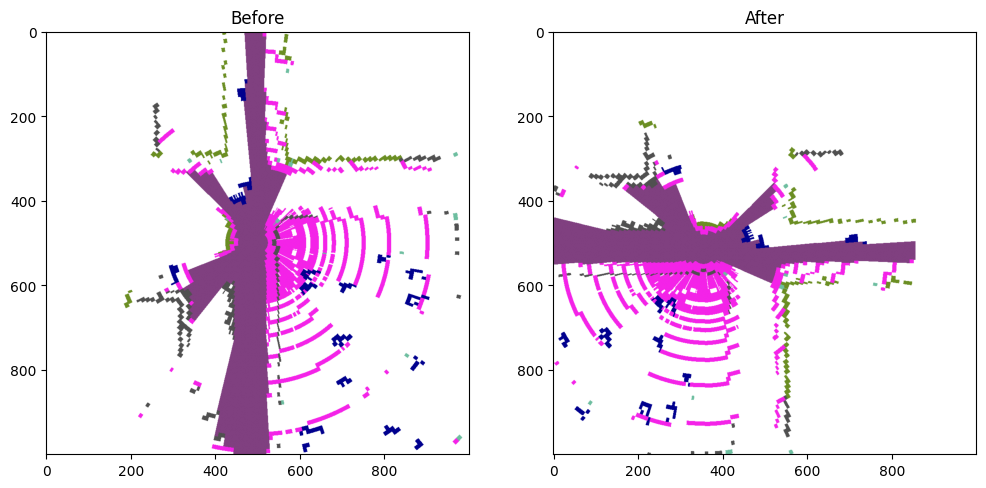

In [42]:
#RESOLUTION=RESOLUTION -25
# Shift the map according the vehicle's poses
def shift_pose_dgm(dgm, init, fin):
  dgm_o = dgm.copy()
  #theta = init[2] /180 * np.pi
  theta = -init[2]
  rot_m = np.array([[np.cos(theta),np.sin(theta)],[-np.sin(theta),np.cos(theta)]])
  trs_m = np.array([[init[0]],[init[1]]])
  point = np.array(fin[:2]).reshape((-1,1))
  point_1 = (point - trs_m)
  point_2 = np.dot(rot_m,-point_1)
  delta_theta = (fin[2] - init[2])
  delta = np.array([point_2[1,0]/RESOLUTION,point_2[0,0]/RESOLUTION,0])



  M = np.array([[1,0,delta[0]],[0,1,-delta[1]]])
  dst = cv2.warpAffine(dgm_o,M,(dgm_o.shape[1],dgm_o.shape[0]))
  M = cv2.getRotationMatrix2D((dgm_o.shape[1]/2+0.5,dgm_o.shape[0]/2+0.5),-delta_theta* 180 / np.pi,1)
  #M = cv2.getRotationMatrix2D((dgm_o.shape[1]/2+0.5,dgm_o.shape[0]/2+0.5),delta_theta,1)
  dst = cv2.warpAffine(dst,M,(dgm_o.shape[1],dgm_o.shape[0]))

  search_value = (0, 0, 0, 0, 0, 0, 0, 0, 0)
  border_value = (1, 0, 0, 0, 0, 0, 0, 0, 0)

  # Create a mask for pixels with the search value
  mask = np.all(dst == search_value, axis=-1)

  # Replace the pixels with the replace value
  dst[mask] = border_value

  return dst

shift_sgm_time_1 = shift_pose_dgm(sgm_time_1,pose1,pose2)

### Visualize
fig,axs = plt.subplots(1,2,figsize=(12,6))
axs[0].imshow(((REDUCED_LABEL_COLORS[np.argmax(sgm_time_1,axis=2).astype(int)])))
axs[0].set_title('Before')
axs[1].imshow(((REDUCED_LABEL_COLORS[np.argmax(shift_sgm_time_1,axis=2).astype(int)])))
axs[1].set_title('After')
plt.show()

In [43]:
print(shift_dgm_time_1[400,200])

[0.32052917 0.         0.67947083]


## The Second Update

Let's update the map again!

The dynamic cells are colored blue.

[0 1 2 3 4 5 6 7]


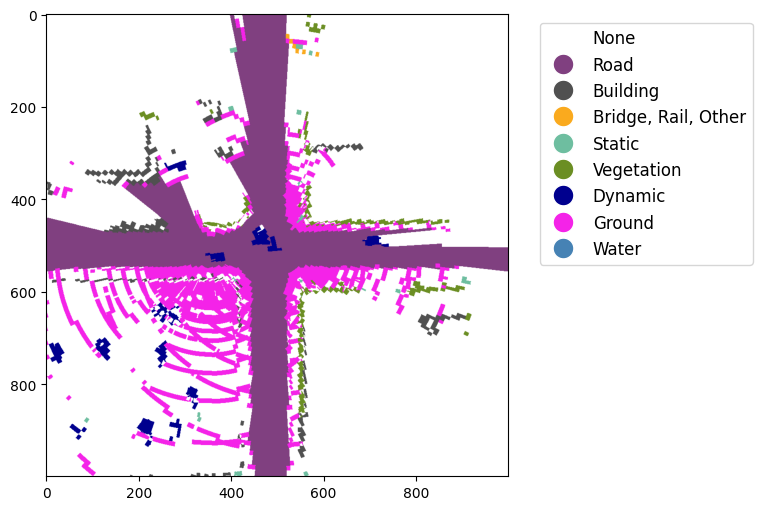

In [44]:
sgm_fuse,dynamic_mass_fuse = update_dgm(shift_sgm_time_1,sgm_time_2)
sgm_pred_fuse = predict_dgm(sgm_fuse,dynamic_mass_fuse,10)

fig,axs = plt.subplots(1,1,figsize=(6,6))
axs.imshow(sgm_pred_fuse)
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=reduced_label_names[i], markerfacecolor=REDUCED_LABEL_COLORS[i], markersize=15) for i in range(len(reduced_label_names))]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='large')

plt.show()

In [45]:
print(dynamic_mass_fuse[100,500])
print(shift_sgm_time_1[100,500])
print(sgm_time_2[100,500])
print(sgm_fuse[100,500])

0.0
[1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.2 0.8 0.  0.  0.  0.  0.  0.  0. ]
[0.2 0.8 0.  0.  0.  0.  0.  0.  0. ]


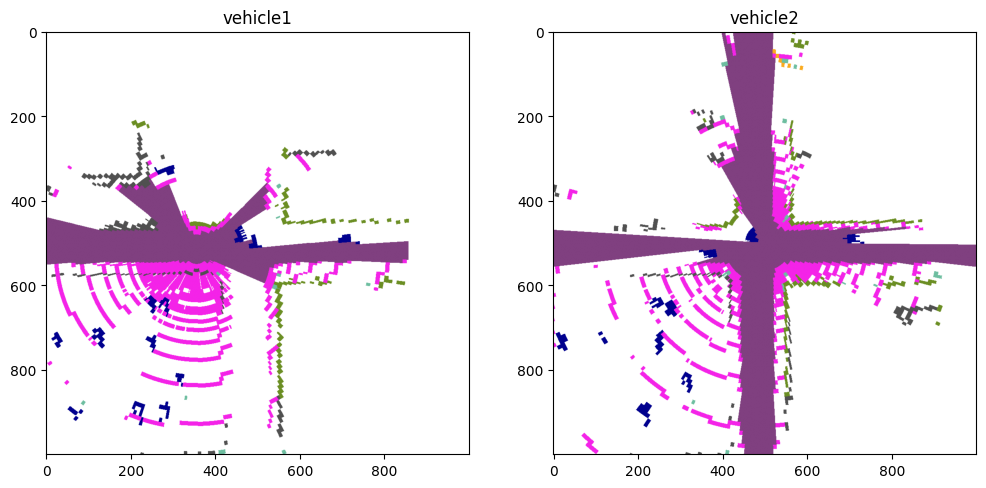

In [46]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
axs[0].imshow(((REDUCED_LABEL_COLORS[np.argmax(shift_sgm_time_1,axis=2).astype(int)])))
axs[0].set_title('vehicle1')
axs[1].imshow(((REDUCED_LABEL_COLORS[np.argmax(sgm_time_2,axis=2).astype(int)])))
axs[1].set_title('vehicle2')
plt.show()

In [47]:

print(shift_sgm_time_1[510,500])
print(sgm_time_2[510,500])
print(sgm_fuse[510,500])

[0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0.2 0.8 0.  0.  0.  0.  0.  0.  0. ]
[1.6 0.8 0.8 0.8 0.8 0.8 1.8 1.6 1.6]


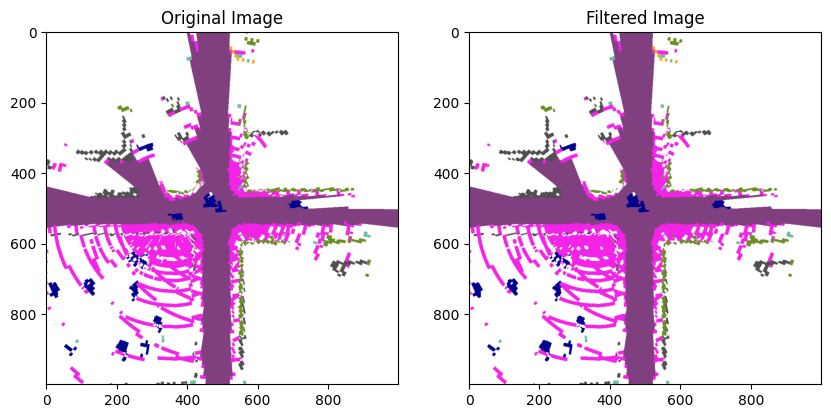

In [48]:
import numpy as np
from scipy.ndimage import median_filter

window_size =5
filtered_image = np.zeros_like(sgm_pred_fuse)
for channel in range(3):
    filtered_image[:, :, channel] = median_filter(sgm_pred_fuse[:, :, channel], size=window_size)

# Display the original and filtered images (optional)

plt.figure(figsize=(10, 12))
plt.subplot(121)
plt.imshow(sgm_pred_fuse)
plt.title('Original Image')
plt.subplot(122)
plt.imshow(filtered_image)
plt.title('Filtered Image')
plt.show()

# Evaluate

/content/drive/MyDrive/s_data/ground truth/scenario5_gt/Vehicle_3 vehicle.citroen.c3/grids/bird_ogm_gt/10.npy
/content/drive/MyDrive/s_data/ground truth/scenario5_gt/Ego_1 vehicle.audi.a2/grids/bird_ogm_gt/10.npy


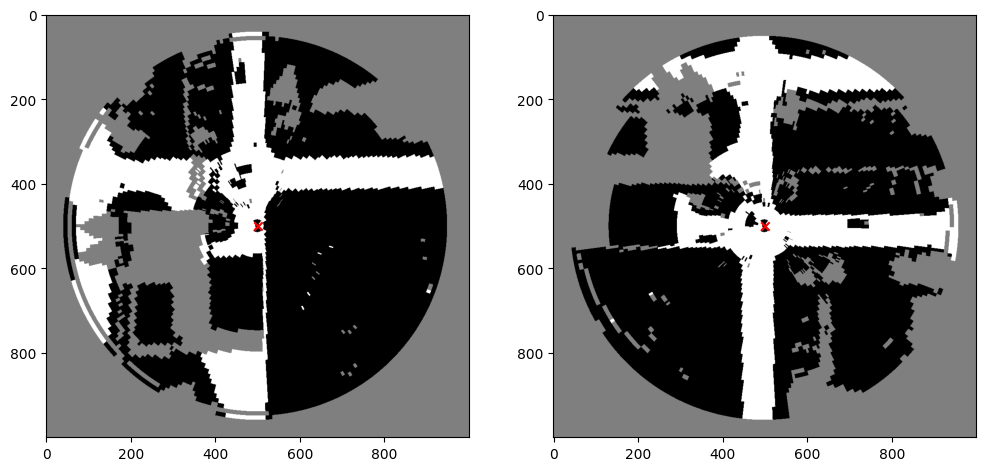

In [50]:
gt1=load_matrix(os.path.join(folder_path1, "grids/bird_ogm_gt"),date)
gt2=load_matrix(os.path.join(folder_path2, "grids/bird_ogm_gt"),date)

### Visualize
fig,axs = plt.subplots(1,2,figsize=(12,6))
axs[0].imshow(((1-gt1)*255).astype(np.uint8),cmap='gray')
axs[0].scatter(500,500,c='r',marker='x')
axs[1].imshow(((1-gt2)*255).astype(np.uint8),cmap='gray')
axs[1].scatter(500,500,c='r',marker='x')
plt.show()

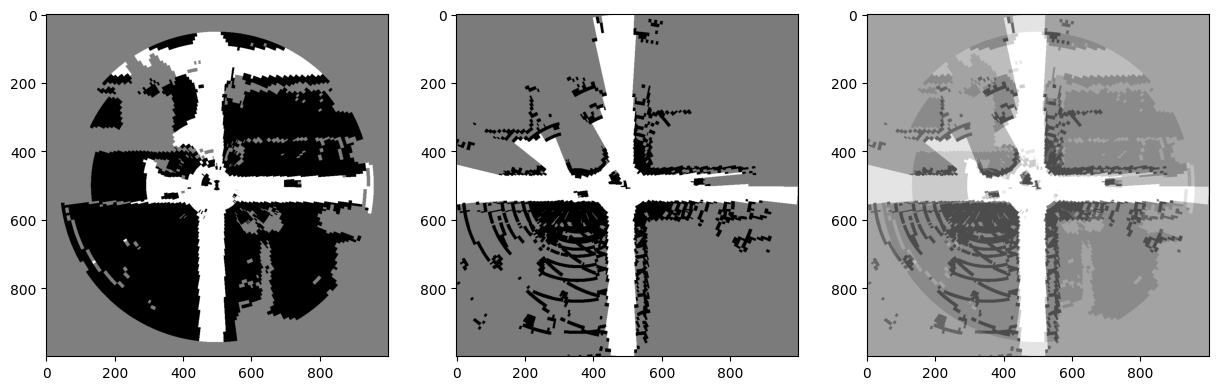

In [51]:
c=((1-gt2)*255).astype(np.uint8)

fig,axs = plt.subplots(1,3,figsize=(15,12))
axs[0].imshow(c,cmap='gray')
axs[1].imshow(dgm_pred_fuse)

axs[2].imshow(c,cmap='gray', alpha=0.4)
axs[2].imshow(dgm_pred_fuse, alpha=0.5)
plt.show()

/content/drive/MyDrive/s_data/ground truth/scenario5_gt/Vehicle_3 vehicle.citroen.c3/grids/bird_semantic_grid/10.npy
/content/drive/MyDrive/s_data/ground truth/scenario5_gt/Ego_1 vehicle.audi.a2/grids/bird_semantic_grid/10.npy


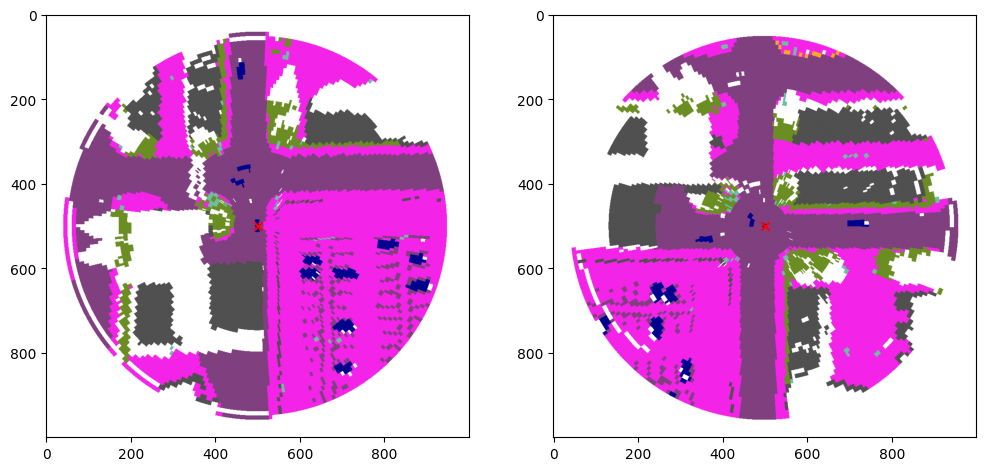

In [53]:
sgt1=load_matrix(os.path.join(folder_path1, "grids/bird_semantic_grid"),date)
sgt2=load_matrix(os.path.join(folder_path2, "grids/bird_semantic_grid"),date)

### Visualize
fig,axs = plt.subplots(1,2,figsize=(12,6))
axs[0].imshow(REDUCED_LABEL_COLORS[sgt1.astype(int)])
axs[0].scatter(500,500,c='r',marker='x')
axs[1].imshow(REDUCED_LABEL_COLORS[sgt2.astype(int)])
axs[1].scatter(500,500,c='r',marker='x')
plt.show()

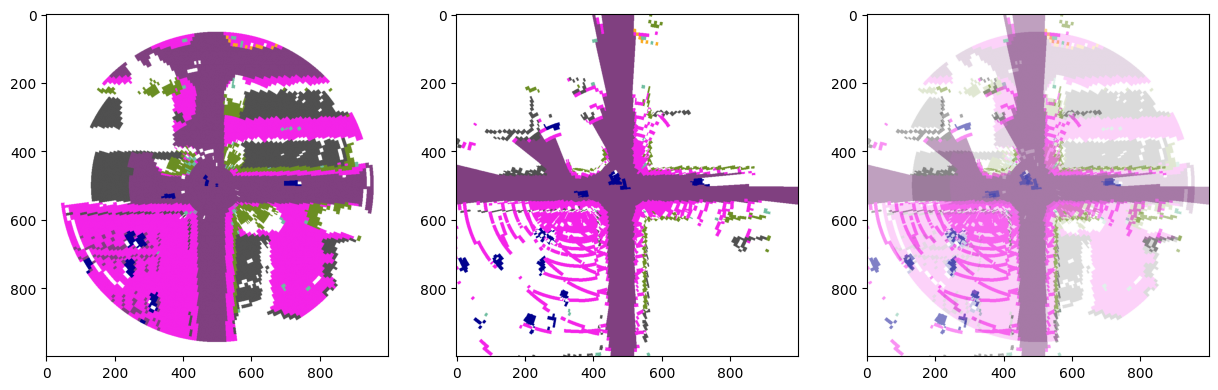

In [54]:
c1=REDUCED_LABEL_COLORS[sgt2.astype(int)]

fig,axs = plt.subplots(1,3,figsize=(15,12))
axs[0].imshow(c1,cmap='gray')
axs[1].imshow(sgm_pred_fuse)

axs[2].imshow(c1,cmap='gray', alpha=0.4)
axs[2].imshow(sgm_pred_fuse, alpha=0.5)
plt.show()